In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from lens_simulation import Lens, Simulation
from scipy import fftpack
from matplotlib import pyplot as plt

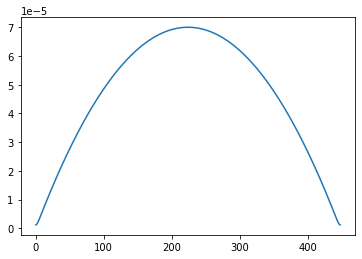

In [48]:
amplitude = 10000
sim_width = 450e-6
pixel_size = 1e-6 
n_slices = 1000

lens = Lens.Lens(
    diameter=sim_width,
    height=70e-6,
    exponent=2.,
    medium=Lens.Medium(2.348)
)
lens.generate_profile(pixel_size=pixel_size)

centre_px = (len(lens.profile)-1)//2

plt.plot(lens.profile)
plt.show()

In [49]:
f=60e-3

equivalent_radius_of_curvature = 0.5 * (
    lens.height + (lens.diameter / 2) ** 2 / lens.height
)

print(equivalent_radius_of_curvature*1e3)

# print((lens.height**2 + (lens.diameter/2)**2)/(2*lens.height))

medium = Lens.Medium(1.0)

equivalent_focal_distance = (
    equivalent_radius_of_curvature * medium.refractive_index
) / (lens.medium.refractive_index - medium.refractive_index)

print(equivalent_focal_distance*1e3)

print('height to get f:')
height=np.sqrt((2*f*(lens.medium.refractive_index-medium.refractive_index))/medium.refractive_index-(lens.diameter/2)**2)
print(height)

a = 1
b = -2*f*(lens.medium.refractive_index-medium.refractive_index)/medium.refractive_index
c = -(lens.diameter/2)**2

h1 = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
h2 = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
print(h1)
print(h2)


0.3966071428571429
0.2942189487070793
height to get f:
0.40219392011192806
0.16176031296304433
-3.1296304435490807e-07


In [46]:
lens_h1 = Lens.Lens(
    diameter=sim_width,
    height=h1,
    exponent=2.,
    medium=Lens.Medium(2.348)
)
lens_h1.generate_profile(pixel_size=pixel_size)

print(Simulation.calculate_equivalent_focal_distance(lens_h1, medium)*1e3)


60.00023216843052


In [41]:
lens_h2 = Lens.Lens(
    diameter=sim_width,
    height=h2,
    exponent=2.,
    medium=Lens.Medium(2.348)
)
lens_h2.generate_profile(pixel_size=pixel_size)

print(Simulation.calculate_equivalent_focal_distance(lens_h2, medium))


-0.04003481018509463
